<h1>Отчёта пока нет</h1>
В отличие от блокнотов с ARPU и FIFA22

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

# для первого запуска (раскомментить):
#!pip install -U polygon-api-client

from polygon import RESTClient

In [2]:
date_format = '%Y-%m-%d'

api_key = 'oOQ9CTHXnX6hb7jKWeN1cYNV6TV3ky9M'

client = RESTClient(api_key)

df = pd.DataFrame()

# 5 API-calls в минуту на бесплатном тарифе

for delta in range(10, 15):
    date = datetime.now() - timedelta(days=delta)
    date = date.strftime(date_format)
    
    # запрашиваем данные торгов за день
    grouped = client.get_grouped_daily_aggs(date)
    grouped = pd.DataFrame(grouped)
    
    # записываем на какую дату получили данные
    grouped['date'] = date
    
    df = pd.concat([df, grouped])

In [3]:
# считаем риск - разницу между ценой открытия и закрытия
df['risk'] = abs(df['open'] - df['close'])

# определяем тип дня для акции в зависимости от направления движения цены
def trend(x):
    if x['close'] < x['open']:
        trend = 'bear'
    elif x['close'] > x['open']:
        trend = 'bull'
    else:
        trend = 'floor'
    return pd.Series({'trend': trend})

# присваиваем тип дня акциям
df['trend'] = df.apply(trend, axis = 1)

# смотрим какой медианный риск - от него будем считать высокорискованные и низкорискованные дни торгов
median = df['risk'].median()

# определяем уровни риска
def risk_group(x):
    if x['risk'] < median:
        risk_group = 'low'
    else:
        risk_group = 'high'
    return pd.Series({'risk_group': risk_group})

# присваиваем уровень риска
df['risk_group'] = df.apply(risk_group, axis = 1)

In [4]:
# подготавливаем данные для 3D-отображения в разрезе тренда, уровня риска и кол-ва акций за период

bar_data = df.groupby(by = ['trend', 'risk_group']).count()
bar_data = bar_data[['ticker']]
bar_data.reset_index(inplace = True)
bar_data.sort_values(by = ['risk_group', 'trend'], ascending = False, inplace = True)
bar_data = bar_data.drop(4) # дропаем акции и дни, когда цена открытия и закрытия одинаковы (trend = floor)

C:\Users\DNS\AppData\Local\Temp\ipykernel_16344\1036785552.py:24: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_ticks(xpos + dx/2.)
C:\Users\DNS\AppData\Local\Temp\ipykernel_16344\1036785552.py:25: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_ticklabels(xlabels)
C:\Users\DNS\AppData\Local\Temp\ipykernel_16344\1036785552.py:27: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_ticks(ypos + dy/2.)
C:\Users\DNS\AppData\Local\Temp\ipykernel_16344\1036785552.py:28: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_ticklabels(ylabels)


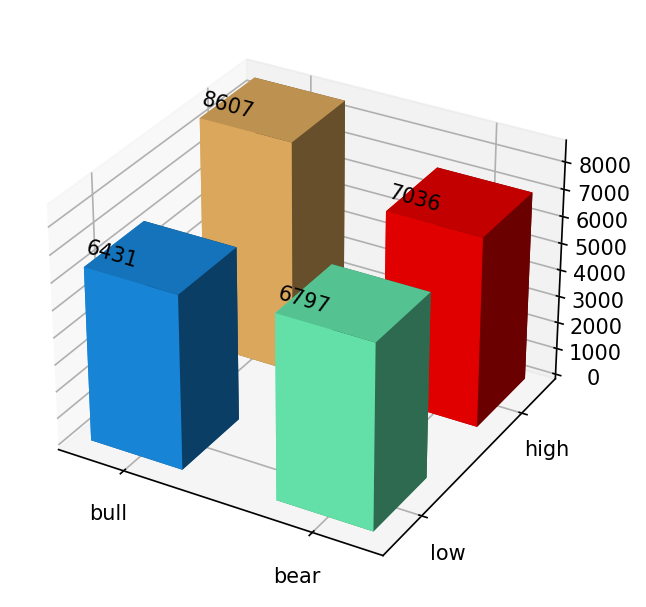

In [5]:
# 3D-визуализация

result=bar_data['ticker']

result = np.array(result, dtype=int)

fig=plt.figure(figsize=(5, 5), dpi=150)
ax=fig.add_subplot(111, projection='3d')

xlabels = np.array(bar_data['trend'].unique())
xpos = np.arange(xlabels.shape[0])
ylabels = np.array(bar_data['risk_group'].unique())
ypos = np.arange(ylabels.shape[0])

xposM, yposM = np.meshgrid(xpos, ypos, copy=False)

zpos=result
zpos = zpos.ravel()

dx=0.5
dy=0.5
dz=zpos

ax.w_xaxis.set_ticks(xpos + dx/2.)
ax.w_xaxis.set_ticklabels(xlabels)

ax.w_yaxis.set_ticks(ypos + dy/2.)
ax.w_yaxis.set_ticklabels(ylabels)

values = np.linspace(0.2, 1., xposM.ravel().shape[0])
colors = cm.rainbow(values)

zdir = 'x'

for x, y, z in zip(xposM.ravel(), yposM.ravel(), dz):
    label = z
    ax.text(x, y, z, label, zdir)

ax.bar3d(xposM.ravel(), yposM.ravel(), dz*0, dx, dy, dz, color=colors)

plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


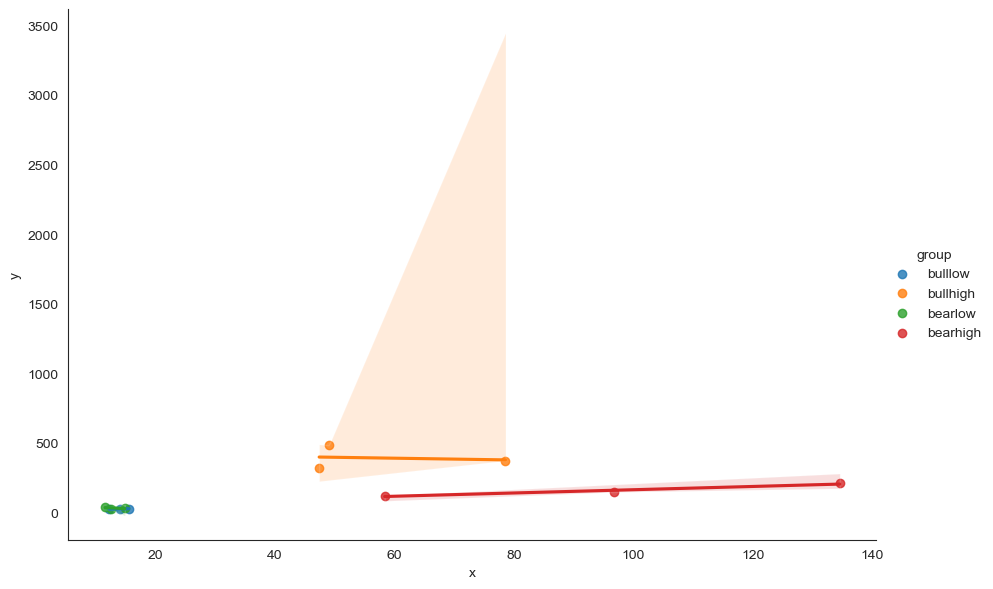

In [6]:
def weighted_average(dataframe, value, weight):
    val = dataframe[value]
    wt = dataframe[weight]
    return (val * wt).sum() / wt.sum()

lm = pd.DataFrame()

for date in df['date'].unique():
    for trend in df['trend'].unique()[:2]:
        for risk_group in df['risk_group'].unique():
            x = weighted_average(df[(df['date'] == date)
                                   & (df['trend'] == trend)
                                   & (df['risk_group'] == risk_group)], 'open', 'volume')
            y = weighted_average(df[(df['date'] == date)
                                   & (df['trend'] == trend)
                                   & (df['risk_group'] == risk_group)], 'open', 'transactions')
            group = trend + risk_group
            output = {'x': x, 'y': y, 'group': group}
            lm = lm._append(output, ignore_index = True)

figsize = (12, 12)
sns.set_style("white")
sns.lmplot(x = 'x', y = 'y', hue = 'group', data=lm, height = 6 , aspect = 1.5)
